# Fpocket benchmark

In [1]:
import os
import re
import time
import torch
import numpy as np
from tqdm import tqdm
from copy import deepcopy
import scipy.spatial as ss

# Bio
from biopandas.mol2 import PandasMol2
from openbabel import openbabel, OBMol, OBConversion 
from Bio.PDB import PDBParser, PDBIO, Select

# Visualization
import pandas as pd
import seaborn as sns
import statistics as stats
import matplotlib.pyplot as plt

/Users/acorrochanon/opt/anaconda3/envs/shapes/lib/python3.9/site-packages/openbabel/__init__.py:14: UserWarning: "import openbabel" is deprecated, instead use "from openbabel import openbabel"
  warnings.warn('"import openbabel" is deprecated, instead use "from openbabel import openbabel"')


### Functions:

We will split the functions the following way:
- scPDB-related
- Fpocket-related 
- Common use

In [2]:
# First position contains the scPDB directory name
paths = [x[0] for x in tqdm(os.walk(os.getcwd()+'/scPDB'))][1:]

17595it [00:02, 7721.07it/s]


### Functions: scPDB-related

In [3]:
# Transform mol2 files contained in scPDB folders to .pdb
def mol2pdb(mol2path, pid, folder_pdb):
    # Open Babel conversion python interface
    obconversion = OBConversion()
    # Turn off warning messages
    openbabel.obErrorLog.SetOutputLevel(0)
    # Set input and output formats
    obconversion.SetInAndOutFormats("mol2", "pdb") 
    # Create openbabel molecule instance
    obmol = OBMol()
    
    # Create folder where all .pdb generated files will be stored. 
    if os.path.isdir(folder_pdb) is not True:
        os.system('mkdir {}'.format(folder_pdb))
    
    # Some protein structures are repeated (there is more than 1 protein-ligand conformation)
    counter = 0
    for directory in ['{}/{}.pdb'.format(folder_pdb, pid),'{}/{}_2.pdb'.format(folder_pdb, pid), 
                      '{}/{}_3.pdb'.format(folder_pdb, pid)]:
        # Check if directory exists
        if os.path.exists(directory):
            counter += 1
                
    # Create the file if it has not been seen previously. 
    if counter == 0:
        # os.system('obabel -imol2 {} -opdb -O MOL2PDB/{}.pdb'.format(mol2path, pid))
        obconversion.ReadFile(obmol, mol2path) 
        obconversion.WriteFile(obmol, '{}/{}.pdb'.format(folder_pdb, pid)) 
        
    # Copy the already existing pdb and paste it with a new name (e.g., 1iki.pdb -> 1iki_1.pdb)
    else:
        os.system('cp {}/{}.pdb {}/{}_{}.pdb'.format(folder_pdb, pid, folder_pdb, pid, counter+1))
    
    return 0


# Return residues ids of those who belong to the first chain
def mol2ChainDetection(path):
    subst_id_chain = []
    main_chain_char = ''
    # We want to iterate only once through ecah file (saving comp. time)
    for p_idx, p in enumerate([path+'/ligand.mol2', path+'/protein.mol2']):
        subst_idx = np.Inf
        for idx, line in enumerate(open(p)):
            if '@<TRIPOS>SUBSTRUCTURE' in line:
                subst_idx = idx  
            # We are finished at this point
            if '@<TRIPOS>SET' in line:
                break
            # Get the rows that are between @SUBSTRUCTURE and @SET sections
            if idx > subst_idx:
                split_line = line.split()
                if p_idx == 0:
                    main_chain_char = split_line[5]
                    break
                else:
                    # Store substructure ID, name (just in case), and chain characters to which the chain belongs.
                    subst_id_chain.append((int(split_line[0]), split_line[1], split_line[5]))
    
    # SOME CASES IN WHICH THE LIGAND.MOL2 CHAIN IS NOT IN THE PROTEIN.MOL2
    chains = [subst_line[2] for subst_line in subst_id_chain]
    if main_chain_char not in set(chains):
        return None, None, None
    
        
    # Get the substructure that belong to the first chain
    filt_subst_ids = [subst[0] for subst in subst_id_chain if subst[2] is main_chain_char]
        
    # Load protein and ligand structures
    pmol = PandasMol2().read_mol2(path+'/protein.mol2')
    lmol = PandasMol2().read_mol2(path+'/ligand.mol2')
    
    # Filter by substructure name
    filt_df = pmol.df[pmol.df['subst_id'].isin(filt_subst_ids)]
    
    # Compute distance between chain selected and ligand 
    centroid_chain_ligand_dist = calculateDistance(getCentroid(torch.Tensor(filt_df[['x','y','z']].values)), 
                                          getCentroid(torch.Tensor(lmol.df[['x','y','z']].values)))
    
    # Calculate the distance for each atom_protein - atom_ligand pair. 
    chain_ligand_dist = 1
    loop_break = False
#     for atom_prot in torch.Tensor(filt_df[['x','y','z']].values):
#         for atom_lig in torch.Tensor(lmol.df[['x','y','z']].values):
#             atom_dist = calculateDistance(atom_prot.unsqueeze(0), atom_lig.unsqueeze(0))
#             if  atom_dist < chain_ligand_dist:
#                 chain_ligand_dist = atom_dist
#                 if chain_ligand_dist < 3:
#                     loop_break = True
#                     break 
#         #if we've found an atom-pair distance under the established threshold. 
#         if loop_break is True:
#             break
                    
    # Verify the substructures id are correct
    assert set(filt_df['subst_id']) == set(filt_subst_ids)

    return filt_subst_ids, chain_ligand_dist, centroid_chain_ligand_dist


# Remove heteroatoms and keep first chain 
def cleanPDB(path, filt_subst_ids):
    pdb_file = path
    # Create instance that will contain protein structure 
    pdb_struct = PDBParser().get_structure(pdb_file.split('.')[0], pdb_file)
    # This way you can see all the chains of the structure  
    # chains = [chain.id for chain in model for model in pdb]
    io = PDBIO()
    io.set_structure(pdb_struct)
    # Keep first chain
    io.save(pdb_file, chainSelect())
    # Remove heteroatoms
    io.save(pdb_file, NonHetSelect(filt_subst_ids))
    return 0


# Remove heteroatoms
class NonHetSelect(Select):
    def __init__(self, filt_subst_ids):
        super().__init__()
        self.ids = filt_subst_ids

    def accept_residue(self, residue):
        # remove heteroatoms and residues from other chains 
        if residue.id[0] == " " and residue.id[1] in self.ids:
            return 1  
        else:
            return 0  
    
    
# Keep one single chain  
class chainSelect(Select):
    def accept_chain(self, chain):
        return 1 if chain.id[0] == 'A' else 0


# Extract cavity geometrical data from file. Returns coordinates and features of the cavity.
def getCavityInfo(path):
    # Create pmol object. 
    pmol = PandasMol2().read_mol2(path)
    # Get coords and atom types. 
    coords = pmol.df[['x', 'y', 'z']].values
    atom_types = pmol.df['atom_name'].values.tolist()
    
    return torch.tensor(coords, dtype = torch.get_default_dtype()), atom_types


# Calculate the volume of the mesh each point cloud/cavity conforms. 
def getPocketVolume(cavity):
    return ss.ConvexHull(cavity).volume


# Extract SCPDB data.  
def getScData(paths, NUM_PROTEINS, folder_pdb):
    # Number of cavities to be extracted can be set (for now). 
    pdb_dict = {}
    skip_count = 0
    
    # Create necessary structures
    sc_cavities, sc_cavities_atypes, sc_volume, points_per_pocket_sc = [], [], [], []
    res_ids, chain_lig_dist, centroid_chain_lig_dist = [], [], []
    
    # Iterate through the paths. 
    for idx, protein_path in enumerate(paths[:NUM_PROTEINS]):
        # Get structures ID
        pid = protein_path.split('/')[-1].split('_')[0]
        
        # ----------REMOVE SPECIAL CASES ------------------
        if pid in ['1got', '1kgi', '1srh']:
            skip_count += 1
            print(pid +' dismissed. Check')
            continue 
            
        # Get the residue ids of the first chain 
        mol2_residues_ids, cldist, ccldist = mol2ChainDetection(protein_path)
        
        # If the ligand does not reference any chain of the protein.mol2, we dismiss it.
        if mol2_residues_ids is None: 
            print(pid +' dismissed. Wrong chain')
            skip_count += 1
            continue 
        
        # If centroids distance is too big, we need to make sure atom-atom distance is low to make sure 
        # ligand is in the stated chain
        if cldist > 3:
            print(pid +' dismissed. Atom pair distance')
            skip_count += 1
            continue 
        
        # Distance between selected chain centroid and ligands
        centroid_chain_lig_dist.append(ccldist)
        # Minimum atom_protein - atom_ligand distance in each protein-ligand complex
        chain_lig_dist.append(cldist)
        # Collect residues from selected chain for posterior cleaning step in remaining .pdb file. 
        res_ids.append(mol2_residues_ids)
        
        # Get coordinates, atom types, and ID
        coords, atypes = getCavityInfo(protein_path+'/cavity6.mol2')
        # Append set of coordinates.
        sc_cavities.append(coords)
        # Append number of coordinates/points cavity has. 
        points_per_pocket_sc.append(len(coords))
        # Append set of features. 
        sc_cavities_atypes.append(atypes)
        # Calculate the volume
        sc_volume.append(getPocketVolume(coords))
        
        # Generate dictionary where key is the pdb ID and value the reading order.
        if pdb_dict.get(pid) is None:
            pdb_dict[pid] = [idx-skip_count]
        else:
            pdb_dict[pid].append(idx-skip_count)
        
        # Mol2 to pdb. folder 'MOL2PDB' is created here.
        mol2pdb(protein_path+'/protein.mol2', pid, folder_pdb)

    
    return sc_cavities, sc_cavities_atypes, points_per_pocket_sc, pdb_dict, sc_volume, res_ids, chain_lig_dist, centroid_chain_lig_dist

### Functions: Fpocket-related

In [4]:
# Extract all desired info of the pocket. Receives the path where the file is located. Returns coordinates, atom
# types, and features (polarity score...)
def extractFpocketInfo(path):
    coords, atom_types = [], []
    
    # Retrieve all data from pocket file
    data = [line for line in open(path)]
    
    # Get index of the line where the coordinates start
    indices, headers = [], []
    for idx, line in enumerate(data):
        if 'ATOM' in line or 'Information' in line:
            indices.append(idx)
        # HEADER required to know where the features end (3UFQ pocket 9 case)
        if 'HEADER' in line:
            headers.append(idx)
        # Only 2 indices wanted. Features starting point and end (it varies depending on fpocket version)
        if len(indices) == 2:
                break
    
    # Get pocket info (volume, Polarity Score...)
    pocket_info = [line.split()[-1] for line in data[(indices[0]+1):(headers[-1]+1)]]
    
    # -2: TER and END
    for atom in data[indices[1]:-2]:
        atom_line_split = atom.split()
        
        # There are format issues with some pocket .pdb files (mixed columns most of the times)
        # Extract coordinates. 
        for idx, col in enumerate(atom_line_split):
            if '.' in col:
                aux = []
                for value in atom_line_split[idx:]:
                    if len(value.split('.')) == 2:
                        aux.append(value)
                    
                    # 2 columns mixed
                    elif len(value.split('.')) == 3:
                        minus_split = value.split('-')
                        minus_indices = [idx for idx, char in enumerate(value) if char == '-']
                        if len(minus_indices) == 1:
                            aux.append(minus_split[0])
                            aux.append('-'+minus_split[1])
                        else:
                            aux.append('-'+minus_split[1])
                            aux.append('-'+minus_split[2])
                    
                    # 3 columns mixed    
                    elif len(value.split('.')) == 4:
                        minus_split = value.split('-')
                        minus_indices = [idx for idx, char in enumerate(value) if char == '-']
                        if len(minus_indices)==3:
                            aux.append('-'+minus_split[1])
                            aux.append('-'+minus_split[2])
                            aux.append('-'+minus_split[3])
                        # If there are 2 minus signs, first element cant be negative
                        else:
                            aux.append(minus_split[0])
                            aux.append('-'+minus_split[1])
                            aux.append('-'+minus_split[2])
                            

                    # Stop iterating when the x,y,z have been stored. 
                    if len(aux) == 3:
                        coords.append(aux)
                        break
                
                # We jump to the next line
                break
        
        # Retrieve atom types. Sometimes the atom type column is combined with the aminoacid chain. 
        if len(atom_line_split[2]) > 4:
            atom_types.append(atom_line_split[2][:-4])
        else:
            atom_types.append(atom_line_split[2])
    
    return torch.Tensor(np.array(coords, dtype='float32')), atom_types, pocket_info


# Calculates all the pockets for the given .pdb file and store them within the given folder name. 
def getFpockets(fname, params = None):
    # Download PDB files first to allow fpocket be executed.
    # If folder is already created (1 is returned) we assume the pockets have been already generated. 
    # Note: If you want to extract pockets from a larger number proteins but you have already executed the method
    # previously, remove the folder and execute it again.
    
    pdb_path_list = []
    for pdb_path in os.walk(os.getcwd()+'/{}'.format(fname)):
        for pdb_file in pdb_path[2]:
            pdb_path_list.append('{}/{}'.format(fname, pdb_file))
    
    # Create txt with all .pdb paths
    txt_name = createTxt(pdb_path_list)
    
    # Run command to extract all the pockets from each pdb. Params are required for the benchmarking exercise.
    if params is not None:
        os.system('fpocket -F {} {}'.format(txt_name, params))
    
    else:
        os.system('fpocket -F {}'.format(txt_name))
    
    # Remove txt file
    os.system('rm {}'.format(txt_name))
    
    return 0


# Create and fill the structures that will handle all the data related to fpocket. 
def generatePocketStructures(folder_pdb, pdb_dict):
    temp_pdb_dict = deepcopy(pdb_dict)
    # Auxiliary structures (protein-level)
    aux_pcoords, aux_patypes, aux_pinfo = [], [], []
    # Order in which pockets are read is extremely important. 
    path_order, pdb_order = [], []

    # Read files within the previously created folder. 
    for idx, path in enumerate(os.walk(os.getcwd()+'/'+folder_pdb)):
        # If 'pockets' is in the path it means current iteration is at some folder filled with pockets.
        if 'pockets' in path[0]:
            fpckt_coords, fpckt_atypes, fpckt_info = [], [], []
            
            # Pockets and files path
            pockets_path = path[0]
            files_path = path[2]

            # If we are at some fake folder. We extract the coordinates from the real one (without the _'fake')
            if 'fake' in pockets_path.split('/')[-2]:
                pockets_path = path[0].replace('fake','out')
                files_path = [i[2] for i in os.walk(pockets_path)][0]
            
            # .pdb reading order within the PDB folder. Order is random. We need to keep track of them.
            pid = pockets_path.split('/')[-2].split('_')[0]
            pid_pos = temp_pdb_dict[pid][0]
            if pid_pos not in pdb_order:
                pdb_order.append(pid_pos)
                # Delete from pdb_ids
                temp_pdb_dict[pid].remove(pid_pos)
        
            # Iterate through the pockets
            for file in files_path:
                if '.pdb' in file:
                    # Order in which proteins and its pockets are read is random
                    # print('{}/{}'.format(path[0], file))
                    path_order.append('{}/{}'.format(pockets_path, file))
                    # Read pockets coord, atom types, and info 
                    pocket_coords, pocket_atypes, pocket_info = extractFpocketInfo('{}/{}'.format(pockets_path, file))
                    # Storage of all the pockets within a particular protein structure. Pocket-level                
                    fpckt_coords.append(pocket_coords)
                    fpckt_atypes.append(pocket_atypes)
                    fpckt_info.append(pocket_info)
    
            # Store the data for all the protein structures (protein-level)
            # index_PDB_ID X index_pocket x index_single_point
            aux_pcoords.append(fpckt_coords)
            aux_patypes.append(fpckt_atypes)
            aux_pinfo.append(fpckt_info)
    
    # CREATE DICTIONARY WITH FEATURES. 
    # Key = Unique integer that represents the feature. # Value = List of all the values the pockets
    # E.g., {9: [200, 134, 567]} (9 = volume)
    fp_info_dict = {}

    # Number of integers will be equal to the number of 'features' (volume, polarity score ...)
    keys = range(len(aux_pinfo[0][0]))

    # Create a list for each feature (in each of them we will append all the pockets values)
    for i in keys:
        fp_info_dict[i] = []

    # dictionary will be filled with all information. 
    for protein in aux_pinfo:
        for pocket in protein:
            for idx, feature in enumerate(pocket):
                fp_info_dict[idx].append(float(feature))
    
    
    return aux_pcoords, aux_patypes, aux_pinfo, fp_info_dict, path_order, pdb_order

### Functions: Common use

In [5]:
# Returns centroid from a given point cloud. Unsqueeze (increase dimensionality) required 
# to compute distance later. Receives a single tensor. 
def getCentroid(point_cloud) -> torch.Tensor:
    return torch.mean(point_cloud, dim = 0).unsqueeze(0)


# Compute euclidean distance between two tensor-type centroids
def calculateDistance(t1, t2) -> float:
    return torch.cdist(t1, t2, p=2).item()


# Return dimension of the input (list) 
def getDepth(a) -> list:
    if not type(a) == list:
        return []
    return [len(a)] + getDepth(a[0])


# Histogram plotting. 
def plotHist(data_list, x_lab, descript, bins = None):    
    plt.figure(figsize=(20, 10))
    #Number of bins used 
    if bins is None:
        bins = int(np.ceil(np.log2(len(data_list))) + 1)
        
    sns.histplot(data_list, bins = bins , kde = True)
    
    # Plot the mean and median.
    plt.axvline(stats.mean(data_list), color='red', label = 'Mean')
    plt.axvline(stats.median(data_list), color='green', label = 'Median')
    
    # Label, title, legend.
    plt.xlabel(x_lab)
    plt.title(descript)
    plt.legend()
    plt.show()


# Flat list of lists
def flatList(list_of_lists) -> list:
    if type(list_of_lists[0][0]) == torch.Tensor and len(list_of_lists[0][0]) == 1:
        return [item.item() for sublist in list_of_lists for item in sublist]
    
    else:
        return [item for sublist in list_of_lists for item in sublist]


# Receives a list of lists. Returns dict 
def atypesToDict(atypes) -> dict:
    # Reduce to unique set of features. 
    unique_atypes = set(atypes)

    # Generate dictionary for posterior mapping/encoding of features.
    dict_atypes = {element:idx for idx, element in enumerate(unique_atypes)}
    
    return dict_atypes


# Generate .txt filled with IDs to download .pdb files later. Removed once is used. 
def createTxt(data):
    file_name = 'temp'
    textfile = open(file_name, "w")
    for idx, element in enumerate(data):
        # If the protein is repeated, e.g. 3lnk_2.pdb, we create a fake folder for later. 3lnk_fake. 
        if '_' in element:
            pid = element.split('/')[-1].split('_')[0]
            os.system('mkdir MOL2PDB/{}_fake; mkdir MOL2PDB/{}_fake/pockets'.format(pid, pid))
            continue
        textfile.write(element+'\n')
    textfile.close()
    
    return file_name


# Obtain final set of labels. 
def getLabels(fp_coords, sc_cavities, pdb_order):
    labels, distances = [], []
    for idx, (fp_protein, order) in enumerate(zip(fp_coords, pdb_order)):
        # Calculate centroid for each point cloud 
        fp_centroids = [getCentroid(pocket) for pocket in fp_protein]

        # Calculate the distance between centoids (fpocket's centroid vs scpdb's)
        # We need to take into account the order in which proteins were read, so we can calculate the distance 
        # with the scPDB cavity of the same structure. 
        p_distances = [calculateDistance(fpcent, getCentroid(sc_cavities[order])) for fpcent in fp_centroids]
        # It has no pockets 
        if len(p_distances) == 0:
            print(check_pdbid(order))
            continue
        # Generate labels. All 0 except for the pocket that holds the closest distance to the scPDB's centroid.
        p_labels = torch.zeros(len(fp_centroids), 1)
        
        # The closest distance will be stored for each pair of centroids for later visualization. 
        distances.append(min(p_distances))
        p_labels[p_distances.index(min(p_distances))] = 1        
        
        # Append to overall list (protein-level)
        labels.append(p_labels)
    
    # Return pocket-level label list. (No list of lists)
    return flatList(labels), distances 


# Find which pockets are the druggable ones 
def findDrugPDBids(distances, labels):
    # Find indices where druggable cavities are located
    drug_idx = np.where(np.array(labels) > 0)[0]
    pocket_id_list = []
    for idx, i in enumerate(drug_idx):
        # Grab ID of fpocket cavity selected as druggable 
        pocket_id = int(path_order[i].split('/')[-1].split('_')[0].replace('pocket',''))
        pocket_id_list.append(pocket_id)
        
        # ---------Pockets that were considered druggable, i.e., held the closest distance to the scPDB cavity 
        # print(idx, path_order[i].split('/')[-3:], round(distances[idx], 2),'Å,',
        # 'Pocket score:', flatList(fp_info)[i][0])

    # Visualize the countplot
    plt.figure(figsize =(20, 10))
    ax = sns.countplot(x = pocket_id_list)
    for p in ax.patches:
        count = p.get_height()
        x = p.get_x() + p.get_width() / 2 - 0.05
        y = p.get_y() + p.get_height()
        ax.annotate(count, (x, y), size = 12)
    plt.xlabel('Pocket ID')
    plt.title('IDs of the most druggable Fpocket cavities')
    plt.show()
    
    return pocket_id_list, drug_idx


# Filter the data with only those cavities with the greatest pocket score and smallest distance 
def filterDataset(pocket_coords, temp_atypes, temp_labels, distances, fpids, drug_idx, path_order):
    # Structure will contain all the ids that need to be removed
    remove_inds = []
    
    # Create temp variables to not delete elements in main structures. 
    copy_pockets = deepcopy(pocket_coords)
    copy_atypes = deepcopy(temp_atypes)
    copy_labels = deepcopy(temp_labels)
    
    # Distance less than 5 and pocket id 0/1.
    for idx, (distance, fpid) in enumerate(zip(distances, fpids)):
        if distance > 5 or fpid > 1:
            remove_inds.append(drug_idx[idx])
    
    # Number of points condition to balance the dataset
    for idx, pocket in enumerate(copy_pockets):
        if len(pocket) < 30:
            if idx not in remove_inds:
                remove_inds.append(idx)
        
    # Remove coordinates, labels, and atom types of the coordinates 
    for rem_idx in sorted(remove_inds, reverse = True):
        del(copy_pockets[rem_idx])
        del(copy_atypes[rem_idx])
        del(path_order[rem_idx])
    
    # Keep the labels of the cavities that were not deleted. 
    copy_labels = np.delete(np.array(temp_labels), remove_inds)
    
    print('Removing {} cavities'.format(len(remove_inds)))
    print('Final number of pockets:{}'.format(len(copy_pockets)))
    
    return copy_pockets, copy_labels, copy_atypes


# Visualize pockets convex hull
def visualizePocket(cavity):
    pts = cavity.numpy()
    hull = ss.ConvexHull(pts)

    fig = plt.figure(figsize=(16, 8))
    ax = fig.add_subplot(111, projection="3d")

    # Plot defining corner points
    ax.plot(pts.T[0], pts.T[1], pts.T[2], "ko")

    for s in hull.simplices:
        s = np.append(s, s[0])  # Here we cycle back to the first coordinate
        ax.plot(pts[s, 0], pts[s, 1], pts[s, 2], "r-")

    # Make axis label
    for i in ["x", "y", "z"]:
        eval("ax.set_{:s}label('{:s}')".format(i, i))
    
    print('Volume estimation (ConvexHull): {:.2f}'.format(hull.volume))
    print('Number of points: {}'.format(len(pts)))
    
    plt.show()
    
    
# Check which pdb id is giving issues
def check_pdbid(index):
    for pos, i in enumerate(pdb_dict.values()):
        if index in i:
            return list(pdb_dict.keys())[pos]

**-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# Fpocket benchmark 

In [6]:
%%capture --no-stdout

# Open files where Jo suggestions are stored.
file = open("fpocket_settings.txt", "r")

# Folder where pdb files will be saved. 
folder_pdb = 'MOL2PDB'

# Retrieve the values
fp_params = [line.replace('\n', '') for line in file]

# Benchmark variables
bench_volumes, bench_points, bench_pockets, bench_distances, bench_times, bench_centroid = [],[],[],[],[],[]
NUM_PATHS = 500
# Iterate through each command.
for idx, params in tqdm(enumerate(fp_params)):
    print('{}: {}'.format(idx, params))
    sc_cavities, sc_cavities_atypes, points_per_pocket_sc, pdb_dict, sc_volumes, res_ids, chain_lig_dist, centroid_chain_lig_dist = getScData(paths, NUM_PATHS, folder_pdb)

    
    # -----------------------------CELL-------------------------------
    # Clean all .pdb files in a new directory (manually created). This is temporary 
    for idx, path in enumerate(os.walk(folder_pdb)):
        for pid in path[2]:
            cleanPDB(path[0]+'/'+pid, res_ids[pdb_dict[pid.replace('.pdb','').split('_')[0]][0]])

    # -----------------------------CELL-------------------------------
    # Get the pockets of each protein. Input is the name of the folder in which pockets will be located.
    start_time = time.time()
    getFpockets(folder_pdb, params)
    print(time.time() - start_time)
    bench_times.append((time.time() - start_time)/60)
    # -----------------------------CELL-------------------------------
    
    # Get coordinates, atom types, features (list and dict), path and .pdb order in which files have been read
    fp_coords, fp_atypes, fp_info, fp_info_dict, path_order, pdb_order = generatePocketStructures(folder_pdb, pdb_dict)
    # Calculate number of pockets per structure 
    pockets_per_struct = [len(fp_info[idx]) for idx in range(len(fp_info))]
    # Calculate number of points per pocket
    points_per_pocket_fp = [len(pocket_fp) for protein_fp in fp_coords for pocket_fp in protein_fp]
    
    # -----------------------------CELL-------------------------------
    
    # Set of labels that will be used and the distances that each pocket holds to the 
    labels, distances = getLabels(fp_coords, sc_cavities, pdb_order)

    # Get the pocket ids of the most druggable cavities 
    pid_list, druggable_indices = findDrugPDBids(distances, labels)
    
    # -----------------------------CELL-------------------------------
    plotHist(distances, 'Distance between chosen pocket centroid and scPDBs (Å)'
         , 'Distribution of distances across the selected pockets', 20)

    print('Mean: {:.2f}'.format(stats.mean(distances)))
    print('Median: {:.2f}'.format(stats.median(distances)))
    
    
    # ----------------------------- END -------------------------------
    # Mean volume, number of pockets per protein, number of points, distances
    bench_volumes.append(stats.mean([getPocketVolume(cav) for cav in flatList(fp_coords)]))
    bench_points.append(stats.mean(points_per_pocket_fp))
    bench_pockets.append(stats.mean(pockets_per_struct))
    bench_distances.append(stats.mean(distances))
    bench_centroid.append(stats.mean(centroid_chain_lig_dist))
    
    # Remove folder with pockets
    os.system('rm -rf {}'.format(folder_pdb))

0: -m 3 -M 6 -i 35 -r 4.5 -s 2.5
4v3i dismissed. Wrong chain
4d2c dismissed. Wrong chain
1srh dismissed. Check
***** POCKET HUNTING BEGINS ***** 
> Protein 492 / 493 : MOL2PDB/3i4d.pdb
***** POCKET HUNTING ENDS ***** 
94.73846411705017
Mean: 4.22
Median: 3.67
1: -m 3 -M 6 -i 35 -r 4.3 -s 2.3
4v3i dismissed. Wrong chain
4d2c dismissed. Wrong chain
1srh dismissed. Check
***** POCKET HUNTING BEGINS ***** 
> Protein 492 / 493 : MOL2PDB/3i4d.pdb
***** POCKET HUNTING ENDS ***** 
94.57882976531982
Mean: 4.06
Median: 3.55
2: -m 3 -M 6 -i 35 -r 4.7 -s 2.7
4v3i dismissed. Wrong chain
4d2c dismissed. Wrong chain
1srh dismissed. Check
***** POCKET HUNTING BEGINS ***** 
> Protein 492 / 493 : MOL2PDB/3i4d.pdb
***** POCKET HUNTING ENDS ***** 
97.43096709251404
Mean: 4.30
Median: 3.72
3: -m 3 -M 6 -i 30 -r 4.5 -s 2.5
4v3i dismissed. Wrong chain
4d2c dismissed. Wrong chain
1srh dismissed. Check
***** POCKET HUNTING BEGINS ***** 
> Protein 492 / 493 : MOL2PDB/3i4d.pdb
***** POCKET HUNTING ENDS ***** 
95

! No Pockets Found while refining
! No pocket to reindex.
! No pocket to reindex.


> Protein 492 / 493 : MOL2PDB/3i4d.pdb
***** POCKET HUNTING ENDS ***** 
78.97933983802795
4x5s
Mean: 3.88
Median: 3.03
20: -m 3.5 -M 6 -i 35 -r 4.7 -s 2.7
4v3i dismissed. Wrong chain
4d2c dismissed. Wrong chain
1srh dismissed. Check
***** POCKET HUNTING BEGINS ***** 
> Protein 492 / 493 : MOL2PDB/3i4d.pdb
***** POCKET HUNTING ENDS ***** 
78.5879738330841
Mean: 3.80
Median: 3.08
21: -m 3.5 -M 6 -i 30 -r 4.5 -s 2.5
4v3i dismissed. Wrong chain
4d2c dismissed. Wrong chain
1srh dismissed. Check
***** POCKET HUNTING BEGINS ***** 
> Protein 492 / 493 : MOL2PDB/3i4d.pdb
***** POCKET HUNTING ENDS ***** 
79.59377908706665
Mean: 3.66
Median: 2.84
22: -m 3.5 -M 6 -i 30 -r 4.3 -s 2.3
4v3i dismissed. Wrong chain
4d2c dismissed. Wrong chain
1srh dismissed. Check
***** POCKET HUNTING BEGINS ***** 
> Protein 492 / 493 : MOL2PDB/3i4d.pdb
***** POCKET HUNTING ENDS ***** 
80.30627489089966
Mean: 3.66
Median: 2.99
23: -m 3.5 -M 6 -i 30 -r 4.7 -s 2.7
4v3i dismissed. Wrong chain
4d2c dismissed. Wrong chain
1

! No Pockets Found while refining
! No pocket to reindex.
! No pocket to reindex.


! No Pockets Found while refining
! No pocket to reindex.
! No pocket to reindex.


> Protein 492 / 493 : MOL2PDB/3i4d.pdb
***** POCKET HUNTING ENDS ***** 
79.2967460155487
1ppk
3gur
Mean: 4.06
Median: 2.93
25: -m 3.5 -M 6 -i 40 -r 4.3 -s 2.3
4v3i dismissed. Wrong chain
4d2c dismissed. Wrong chain
1srh dismissed. Check
***** POCKET HUNTING BEGINS ***** 


! No Pockets Found while refining
! No pocket to reindex.
! No pocket to reindex.


! No Pockets Found while refining
! No pocket to reindex.
! No pocket to reindex.


! No Pockets Found while refining
! No pocket to reindex.
! No pocket to reindex.


! No Pockets Found while refining
! No pocket to reindex.
! No pocket to reindex.


! No Pockets Found while refining
! No pocket to reindex.
! No pocket to reindex.


> Protein 492 / 493 : MOL2PDB/3i4d.pdb
***** POCKET HUNTING ENDS ***** 
78.6934461593628
1tl7
1ppk
3gur
4klb
4x5s
Mean: 4.08
Median: 3.05
26: -m 3.5 -M 6 -i 40 -r 4.7 -s 2.7
4v3i dismissed. Wrong chain
4d2c dismissed. Wrong chain
1srh dismissed. Check
***** POCKET HUNTING BEGINS ***** 


! No Pockets Found while refining
! No pocket to reindex.
! No pocket to reindex.


! No Pockets Found while refining
! No pocket to reindex.
! No pocket to reindex.


> Protein 492 / 493 : MOL2PDB/3i4d.pdb
***** POCKET HUNTING ENDS ***** 
78.13421678543091
1ppk
3gur
Mean: 3.89
Median: 3.13


In [137]:
pos_min_distance = bench_distances.index(bench_distances[21])

print('Best params (Based on distance):', fp_params[pos_min_distance])
print('Distance (average):', bench_distances[pos_min_distance])
print('Pockets per protein (average):', bench_pockets[pos_min_distance])
print('Pocket volume (average):', bench_volumes[pos_min_distance])
print('Points per pocket (average):', bench_points[pos_min_distance])
print('Total number of pockets:',bench_pockets[pos_min_distance]*200)

Best params (Based on distance): -m 3.5 -M 6 -i 30 -r 4.5 -s 2.5
Distance (average): 3.6629058910267696
Pockets per protein (average): 11.169014084507042
Pocket volume (average): 740.2073553988864
Points per pocket (average): 33.498648892091516
Total number of pockets: 2233.8028169014083


<Figure size 2160x1440 with 0 Axes>

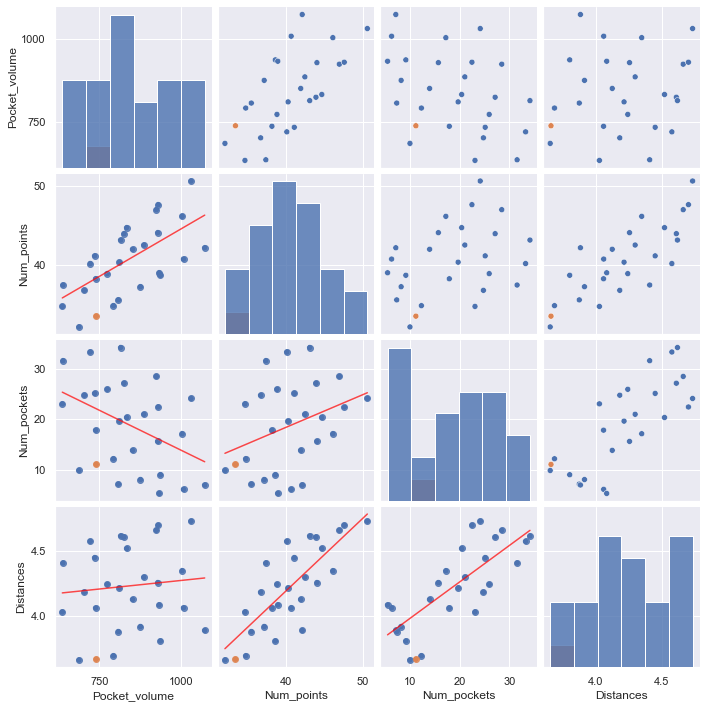

In [136]:
from scipy.stats import pearsonr

sns.reset_orig
chosen = np.zeros(27)
chosen[21] = 1

d = {'Pocket_volume':bench_volumes, 'Num_points': bench_points, 
     'Num_pockets': bench_pockets, 'Distances':bench_distances, 'Best':chosen}
bench_df = pd.DataFrame(data = d)


def corrfunc(x, y, ax=None, **kws):
    """Plot the correlation coefficient in the top left hand corner of a plot."""
    r, _ = pearsonr(x, y)
    ax = ax or plt.gca()
    ax.annotate(f'r2 = {r:.2f}', xy=(.1, .9), xycoords=ax.transAxes)

def func(y, ax=None, **kws):
    
    ax.catplot(x = np.arange(27), y = y)


plt.figure(figsize = (30, 20))
g = sns.pairplot(data = bench_df, diag_kind = 'hist', hue='Best', diag_kws = {'alpha':0.8})
g.map_lower(sns.regplot, ci = False, line_kws={'color': 'red', 'lw': 1.5, 'alpha': 0.7})
g._legend.remove()
sns.set(font_scale=15)
plt.savefig('Images/500_pairplot', dpi = 300)
plt.show()
# g.map_lower(corrfunc)


In [138]:
# Save values in order to not rerun benchmark.
torch.save(bench_distances, 'data/bench_distances_500.pt')
torch.save(bench_pockets, 'data/bench_pockets_500.pt')
torch.save(bench_volumes, 'data/bench_volumes_500.pt')
torch.save(bench_points, 'data/bench_points_500.pt')